# Replicating ResNet as done in Nakkirran et al. to reproduce Model-Wise Double Descent

In [29]:
# Let's import the necessary libraries
import torch
import torch.nn.functional as F
import torchvision
import torch.nn as nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
import wandb
from torch.utils.data import TensorDataset, Subset, DataLoader, Dataset
from torchvision import datasets, transforms

In [7]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")

device = 'mps' # 'cuda' if torch.cuda.is_available() else 'cpu'

In [32]:
on_colab = False
use_adam_op = True
augmented = True
use_label_noise = False
pytorch_default_resnet = False
num_classes = 10
frac_label_noise = 0.15
batch_size = 256
lr = 0.0001
epochs = 1500
model_seed = 42
data_seed = 42

In [4]:
'''if on_colab == True:
    from google.colab import drive
    drive.mount('/conten/gdrive')'''

"if on_colab == True:\n    from google.colab import drive\n    drive.mount('/conten/gdrive')"

In [35]:
## ResNet18 for CIFAR
## Based on: https://gitlab.com/harvard-machine-learning/double-descent/-/blob/master/models/resnet18k.py

class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, **kwargs):
        super(PreActBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                          nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.bn1(x)
        out = self.relu(out)
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out += shortcut
        return out

class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes, init_channels):
        super(PreActResNet, self).__init__()
        self.in_planes = init_channels
        c = init_channels

        self.conv1 = nn.Conv2d(3, c, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(c)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        self.layer1 = self._make_layer(block, c, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 2*c, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 4*c, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 8*c, num_blocks[3], stride=2)
        self.avpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.linear = nn.Linear(8*c*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        # eg: [2, 1, 1, ..., 1]. Only the first one downsamples.
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def make_resnet18k(k, num_classes) -> PreActResNet:
    ''' Returns a ResNet18 with width parameter k. (k=64 is standard ResNet18)'''
    return PreActResNet(PreActBlock, [2, 2, 2, 2], num_classes=num_classes, init_channels=k)

In [6]:
make_resnet18k(64, 10)

PreActResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): PreActBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): PreActBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=

In [36]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [37]:
widths = [1, 2, 4, 8, 16, 32, 64]
models = []

for i in widths:
  if model_seed is not None:
    torch.manual_seed(model_seed)
    model = make_resnet18k(i, num_classes=num_classes)
    model.to(device)
    models.append(model)

for i in range(len(models)):
  print(f'Parameter Counts for model width {widths[i]}: {count_parameters(models[i])}')

Parameter Counts for model width 1: 3097
Parameter Counts for model width 2: 11632
Parameter Counts for model width 4: 45046
Parameter Counts for model width 8: 177250
Parameter Counts for model width 16: 703162
Parameter Counts for model width 32: 2801002
Parameter Counts for model width 64: 11180746


In [38]:
# Let's import the CIFAR10 dataset from torchvision
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) if not augmented else transforms.Compose([transforms.ToTensor(), transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

if data_seed is not None:
    torch.manual_seed(data_seed)

train_set = datasets.CIFAR10(root='./data',
                             train=True,
                             download=True,
                             transform=transform)
trainloader = DataLoader(train_set,
                         batch_size=batch_size,
                         shuffle=True
                         )

test_set = datasets.CIFAR10(root='./data',
                            train=False,
                            download=True,
                            transform=transform)
testloader = DataLoader(test_set,
                        shuffle=False,
                        batch_size=batch_size
                        )

Files already downloaded and verified
Files already downloaded and verified


In [10]:
np.random.seed(data_seed)
num_noise = int(frac_label_noise * len(trainloader.dataset.data))
true_targets = trainloader.dataset.targets

labels = torch.from_numpy(np.array(true_targets)).clone()
corrupt_indices = np.random.permutation(len(true_targets))[:num_noise]
check_labels = labels[corrupt_indices].tolist() # I will use this to cross-chec
labels, corrupt_indices, labels[corrupt_indices], check_labels, np.unique(labels[corrupt_indices].tolist(), return_counts=True)

(tensor([6, 9, 9,  ..., 9, 1, 1]),
 array([33553,  9427,   199, ...,  6166, 35101,  3594]),
 tensor([7, 8, 0,  ..., 8, 3, 3]),
 [7,
  8,
  0,
  6,
  1,
  6,
  8,
  0,
  6,
  5,
  2,
  5,
  0,
  7,
  1,
  6,
  5,
  6,
  6,
  5,
  0,
  5,
  7,
  2,
  4,
  4,
  5,
  5,
  4,
  8,
  4,
  3,
  5,
  0,
  0,
  8,
  0,
  1,
  8,
  0,
  3,
  0,
  0,
  0,
  9,
  4,
  4,
  6,
  7,
  6,
  9,
  0,
  9,
  9,
  4,
  3,
  6,
  2,
  9,
  9,
  8,
  4,
  4,
  8,
  1,
  1,
  3,
  9,
  1,
  5,
  0,
  3,
  0,
  2,
  2,
  7,
  8,
  3,
  1,
  8,
  7,
  5,
  4,
  0,
  5,
  7,
  8,
  1,
  1,
  4,
  8,
  3,
  2,
  2,
  5,
  9,
  7,
  7,
  8,
  8,
  3,
  4,
  6,
  1,
  7,
  8,
  3,
  7,
  1,
  7,
  6,
  4,
  3,
  0,
  4,
  6,
  0,
  8,
  3,
  3,
  8,
  9,
  6,
  5,
  1,
  4,
  9,
  2,
  4,
  3,
  2,
  4,
  1,
  0,
  1,
  6,
  4,
  2,
  8,
  2,
  7,
  1,
  3,
  6,
  5,
  8,
  8,
  5,
  4,
  6,
  4,
  1,
  3,
  7,
  1,
  7,
  8,
  7,
  1,
  1,
  2,
  5,
  9,
  1,
  9,
  2,
  4,
  5,
  5,
  2,
  2,
  3,
  6,
  3,
  5

In [11]:
import pandas as pd

In [12]:
d = pd.read_csv('label_noise/fifteen_percent_label_noise.csv')
deranged = d.values
deranged = deranged.squeeze(1)
deranged = deranged.tolist()
print(deranged)

[1, 2, 5, 1, 8, 1, 5, 9, 9, 8, 8, 0, 5, 9, 6, 0, 8, 2, 0, 8, 6, 1, 4, 6, 5, 1, 6, 1, 2, 6, 3, 7, 6, 5, 5, 4, 7, 9, 7, 5, 7, 9, 6, 9, 0, 8, 0, 8, 8, 7, 4, 6, 8, 3, 7, 4, 5, 4, 8, 7, 1, 3, 0, 0, 0, 4, 5, 4, 6, 0, 4, 2, 1, 3, 8, 1, 0, 5, 0, 4, 2, 7, 9, 3, 2, 4, 3, 0, 0, 5, 4, 8, 3, 7, 2, 8, 0, 9, 5, 0, 6, 7, 5, 8, 6, 1, 6, 9, 2, 3, 1, 3, 4, 2, 5, 3, 7, 4, 0, 1, 7, 1, 2, 4, 2, 9, 1, 6, 1, 7, 9, 6, 7, 5, 0, 3, 3, 5, 7, 8, 5, 9, 2, 1, 8, 2, 1, 0, 1, 1, 2, 8, 1, 2, 6, 1, 4, 8, 7, 9, 3, 8, 5, 4, 5, 4, 9, 7, 4, 4, 5, 5, 4, 8, 7, 3, 1, 0, 8, 3, 3, 2, 6, 3, 5, 8, 2, 1, 4, 6, 4, 3, 8, 6, 1, 8, 4, 5, 6, 3, 7, 8, 7, 3, 3, 2, 1, 4, 5, 4, 2, 7, 1, 7, 4, 2, 4, 5, 4, 5, 4, 9, 8, 9, 7, 8, 1, 4, 5, 0, 8, 7, 9, 9, 0, 5, 0, 7, 9, 2, 0, 9, 6, 0, 5, 4, 2, 1, 5, 3, 9, 4, 9, 7, 4, 1, 9, 2, 9, 9, 6, 1, 4, 4, 1, 6, 2, 7, 5, 1, 6, 4, 9, 9, 7, 5, 5, 5, 9, 6, 6, 7, 0, 8, 9, 7, 5, 1, 6, 4, 3, 2, 0, 2, 7, 0, 4, 3, 8, 6, 7, 0, 8, 6, 2, 6, 2, 5, 1, 3, 8, 9, 4, 2, 9, 2, 6, 8, 5, 7, 8, 4, 0, 3, 7, 7, 3, 6, 9, 1, 1, 7, 1, 

In [13]:
labels[corrupt_indices] = torch.from_numpy(np.array(deranged))
labels[corrupt_indices]

tensor([1, 2, 5,  ..., 6, 6, 4])

In [14]:
labels = labels.tolist()

In [15]:
# Let's change the labels in the initial trainloader with the noisy labels
if use_label_noise:
    trainloader.dataset.targets = labels

In [16]:
criterion = nn.CrossEntropyLoss(reduction='mean').to(device)
dl = trainloader #if not use_label_noise else new_dataloader

In [17]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sienka. Use `wandb login --relogin` to force relogin


True

In [18]:
print("Training on", device)

final_model_train_losses = []
final_model_test_losses = []
final_model_train_accuracies = []
final_model_test_accuracies = []

for i in range(len(models)):
  model = models[i]
  optimizer = optim.SGD(model.parameters(), lr, momentum=0.9, weight_decay=5e-10) if not use_adam_op else optim.Adam(model.parameters(), lr)
  print(f"Started training for model width {widths[i]}")
  wandb.init(project="SLT of Double Descent",
           config = {'epochs': epochs,
                     'classes': num_classes,
                     'learning_rate': lr,
                     'use_label_noise': use_label_noise,
                     'noise_level': frac_label_noise,
                     'dataset': "CIFAR10",
                     'architecture': "ResNet18",
                     'pytorch_resnet_model': pytorch_default_resnet,
                     'model_width': models[i],
                     'augmented': augmented,
                     'adam optimizer': use_adam_op}
                     )

  wandb.watch(model)
  config = wandb.config

  test_losses = []
  train_losses = []
  train_accs = []
  test_accs = []

  step = 0
  for epoch in range(epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    train_acc = 0.0

    for j, data in enumerate(dl):
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      outputs = model(images)
      batch_loss = criterion(outputs, labels)

      predictions = outputs.argmax(axis=-1)
      train_acc += torch.sum(predictions == labels).item()
      train_loss += batch_loss.item()

      batch_loss.backward()
      optimizer.step()

      step += 1

      wandb.log({'batch_loss': batch_loss.item()}, step=step)

    # Calculate average training loss for the epoch
    train_loss /= len(trainloader)
    train_acc /= len(trainloader.dataset.data)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation (or test) loop
    model.eval()

    test_loss = 0.0
    test_acc = 0.0

    with torch.no_grad():
      for k, test_data in enumerate(testloader):
        test_images, test_labels = test_data
        test_images = test_images.to(device)
        test_labels = test_labels.to(device)

        outputs = model(test_images)
        batch_test_loss = criterion(outputs, test_labels)
        test_loss += batch_test_loss.item()

        predictions = outputs.argmax(axis=-1)
        test_acc += torch.sum(predictions == test_labels).item()

    # Let's calculate average test loss for the epoch
    test_loss /= len(testloader)
    test_acc /= len(testloader.dataset.data)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    wandb.log({'epoch': epoch,
                'loss/train': train_loss,
                'loss/test': test_loss,
                'accuracy/train': train_acc,
                'accuracy/test': test_acc
            }, step=step)


    # Print or log the training and test losses for each epoch
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

  prefix = 'model' + '_width' + str(widths[i])
  FILENAME = prefix +'.pth' if not use_label_noise else prefix + '_with_noise.pth'
  Path = f'/content/gdrive/My Drive/{FILENAME}'

  torch.save(model.state_dict(), FILENAME) if not on_colab else torch.save(model.state_dict(), Path) 
  wandb.finish()
  trl = np.array(train_losses)
  tel = np.array(test_losses)
  teac = np.array(test_accs)
  trl = pd.DataFrame(trl)
  tel = pd.DataFrame(tel)
  teac = pd.DataFrame(teac)
  trl.to_csv(prefix + "clean_train_losses.csv", index=False) if not use_label_noise else trl.to_csv(prefix + "train_losses_with_label_noise.csv", index=False)
  tel.to_csv(prefix + "clean_test_losses.csv", index=False) if not use_label_noise else tel.to_csv(prefix + "test_losses_with_label_noise.csv", index=False)
  teac.to_csv(prefix + "clean_test_accs.csv", index=False) if not use_label_noise else teac.to_csv(prefix + "test_accs_with_label_noise.csv", index=False)

  final_model_train_losses.append(train_loss)
  final_model_test_losses.append(test_loss)
  final_model_train_accuracies.append(train_acc)
  final_model_test_accuracies.append(test_acc)

print('Finished taining models!')

Training on mps
Started training for model width 1


Epoch 1/1500, Train Loss: 2.4431, Test Loss: 2.3662
Epoch 2/1500, Train Loss: 2.3182, Test Loss: 2.2782
Epoch 3/1500, Train Loss: 2.2532, Test Loss: 2.2265
Epoch 4/1500, Train Loss: 2.2093, Test Loss: 2.1879
Epoch 5/1500, Train Loss: 2.1747, Test Loss: 2.1546
Epoch 6/1500, Train Loss: 2.1489, Test Loss: 2.1294
Epoch 7/1500, Train Loss: 2.1278, Test Loss: 2.1086
Epoch 8/1500, Train Loss: 2.1097, Test Loss: 2.0920
Epoch 9/1500, Train Loss: 2.0933, Test Loss: 2.0770
Epoch 10/1500, Train Loss: 2.0777, Test Loss: 2.0629
Epoch 11/1500, Train Loss: 2.0657, Test Loss: 2.0494
Epoch 12/1500, Train Loss: 2.0536, Test Loss: 2.0383
Epoch 13/1500, Train Loss: 2.0442, Test Loss: 2.0292
Epoch 14/1500, Train Loss: 2.0358, Test Loss: 2.0192
Epoch 15/1500, Train Loss: 2.0275, Test Loss: 2.0110
Epoch 16/1500, Train Loss: 2.0207, Test Loss: 2.0028
Epoch 17/1500, Train Loss: 2.0140, Test Loss: 1.9962
Epoch 18/1500, Train Loss: 2.0077, Test Loss: 1.9894
Epoch 19/1500, Train Loss: 2.0014, Test Loss: 1.9834
Ep

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy/test,▁▄▅▆▆▇▇▇▇▇▇▇▇█▇█▇███████████████████████
accuracy/train,▁▃▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████████████
batch_loss,█▇▅▄▆▆▄▃▃▄▄▃▃▅▂▄▃▄▄▃▄▃▂▅▂▁▃▂▃▂▄▂▂▃▃▄▂▂▄▃
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/test,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy/test,0.4031
accuracy/train,0.4138
batch_loss,1.64858
epoch,1499
loss/test,1.6343


Started training for model width 2


Epoch 1/1500, Train Loss: 2.3709, Test Loss: 2.2592
Epoch 2/1500, Train Loss: 2.1987, Test Loss: 2.1457
Epoch 3/1500, Train Loss: 2.0973, Test Loss: 2.0545
Epoch 4/1500, Train Loss: 2.0145, Test Loss: 1.9791
Epoch 5/1500, Train Loss: 1.9508, Test Loss: 1.9244
Epoch 6/1500, Train Loss: 1.9009, Test Loss: 1.8817
Epoch 7/1500, Train Loss: 1.8672, Test Loss: 1.8489
Epoch 8/1500, Train Loss: 1.8392, Test Loss: 1.8249
Epoch 9/1500, Train Loss: 1.8168, Test Loss: 1.8065
Epoch 10/1500, Train Loss: 1.7970, Test Loss: 1.7875
Epoch 11/1500, Train Loss: 1.7806, Test Loss: 1.7710
Epoch 12/1500, Train Loss: 1.7664, Test Loss: 1.7592
Epoch 13/1500, Train Loss: 1.7533, Test Loss: 1.7453
Epoch 14/1500, Train Loss: 1.7399, Test Loss: 1.7372
Epoch 15/1500, Train Loss: 1.7285, Test Loss: 1.7259
Epoch 16/1500, Train Loss: 1.7182, Test Loss: 1.7159
Epoch 17/1500, Train Loss: 1.7075, Test Loss: 1.7060
Epoch 18/1500, Train Loss: 1.6978, Test Loss: 1.6978
Epoch 19/1500, Train Loss: 1.6889, Test Loss: 1.6916
Ep

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy/test,▁▄▆▇▇▇▇█████████████████████████████████
accuracy/train,▁▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇████████████████████████
batch_loss,█▆▅▅▄▄▄▂▄▄▃▄▄▃▂▃▄▃▃▃▂▃▄▄▃▃▃▄▂▃▃▄▃▃▄▂▃▂▃▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/test,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
loss/train,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy/test,0.4848
accuracy/train,0.54704
batch_loss,1.34286
epoch,1499
loss/test,1.4454


Started training for model width 4


Epoch 1/1500, Train Loss: 2.2294, Test Loss: 2.0908
Epoch 2/1500, Train Loss: 2.0057, Test Loss: 1.9227
Epoch 3/1500, Train Loss: 1.8755, Test Loss: 1.8167
Epoch 4/1500, Train Loss: 1.7838, Test Loss: 1.7372
Epoch 5/1500, Train Loss: 1.7182, Test Loss: 1.6824
Epoch 6/1500, Train Loss: 1.6717, Test Loss: 1.6411
Epoch 7/1500, Train Loss: 1.6372, Test Loss: 1.6185
Epoch 8/1500, Train Loss: 1.6113, Test Loss: 1.5886
Epoch 9/1500, Train Loss: 1.5882, Test Loss: 1.5729
Epoch 10/1500, Train Loss: 1.5674, Test Loss: 1.5553
Epoch 11/1500, Train Loss: 1.5477, Test Loss: 1.5451
Epoch 12/1500, Train Loss: 1.5303, Test Loss: 1.5258
Epoch 13/1500, Train Loss: 1.5145, Test Loss: 1.5158
Epoch 14/1500, Train Loss: 1.5016, Test Loss: 1.5035
Epoch 15/1500, Train Loss: 1.4893, Test Loss: 1.4931
Epoch 16/1500, Train Loss: 1.4758, Test Loss: 1.4899
Epoch 17/1500, Train Loss: 1.4644, Test Loss: 1.4778
Epoch 18/1500, Train Loss: 1.4535, Test Loss: 1.4716
Epoch 19/1500, Train Loss: 1.4443, Test Loss: 1.4673
Ep

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy/test,▁▆████▇▇▆▆▅▅▅▅▄▄▄▄▃▄▃▄▃▃▃▄▃▃▃▃▃▃▃▃▃▄▃▃▄▃
accuracy/train,▁▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████████████
batch_loss,█▇▅▅▄▃▃▄▂▄▃▃▄▄▃▃▁▃▂▅▁▂▂▂▂▁▂▂▂▂▃▂▂▃▂▃▂▂▂▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/test,▃▁▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇█▇██████
loss/train,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy/test,0.4698
accuracy/train,0.70102
batch_loss,0.8208
epoch,1499
loss/test,1.88838


Started training for model width 8


Epoch 1/1500, Train Loss: 2.0397, Test Loss: 1.8315
Epoch 2/1500, Train Loss: 1.7281, Test Loss: 1.6366
Epoch 3/1500, Train Loss: 1.5996, Test Loss: 1.5478
Epoch 4/1500, Train Loss: 1.5250, Test Loss: 1.4974
Epoch 5/1500, Train Loss: 1.4681, Test Loss: 1.4581
Epoch 6/1500, Train Loss: 1.4264, Test Loss: 1.4261
Epoch 7/1500, Train Loss: 1.3881, Test Loss: 1.4024
Epoch 8/1500, Train Loss: 1.3550, Test Loss: 1.3836
Epoch 9/1500, Train Loss: 1.3261, Test Loss: 1.3683
Epoch 10/1500, Train Loss: 1.3003, Test Loss: 1.3532
Epoch 11/1500, Train Loss: 1.2770, Test Loss: 1.3418
Epoch 12/1500, Train Loss: 1.2562, Test Loss: 1.3361
Epoch 13/1500, Train Loss: 1.2361, Test Loss: 1.3298
Epoch 14/1500, Train Loss: 1.2161, Test Loss: 1.3222
Epoch 15/1500, Train Loss: 1.1991, Test Loss: 1.3133
Epoch 16/1500, Train Loss: 1.1793, Test Loss: 1.3106
Epoch 17/1500, Train Loss: 1.1643, Test Loss: 1.3042
Epoch 18/1500, Train Loss: 1.1469, Test Loss: 1.3090
Epoch 19/1500, Train Loss: 1.1320, Test Loss: 1.2998
Ep

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy/test,██▆▃▄▃▂▂▂▃▂▂▂▁▂▂▁▂▂▁▁▂▁▁▁▂▂▂▂▂▃▂▁▂▂▁▂▂▂▂
accuracy/train,▁▃▅▆▇▇▇▇▇▇▇█████████████████████████████
batch_loss,█▆▄▃▃▂▂▃▁▂▂▂▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▃▁▁▂▂▁▁▂▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/test,▁▁▂▃▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
loss/train,█▆▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy/test,0.4796
accuracy/train,0.97982
batch_loss,0.30325
epoch,1499
loss/test,5.94587


Started training for model width 16


Epoch 1/1500, Train Loss: 1.8696, Test Loss: 1.6249
Epoch 2/1500, Train Loss: 1.5254, Test Loss: 1.4496
Epoch 3/1500, Train Loss: 1.3781, Test Loss: 1.3665
Epoch 4/1500, Train Loss: 1.2821, Test Loss: 1.3142
Epoch 5/1500, Train Loss: 1.2021, Test Loss: 1.2810
Epoch 6/1500, Train Loss: 1.1353, Test Loss: 1.2610
Epoch 7/1500, Train Loss: 1.0752, Test Loss: 1.2560
Epoch 8/1500, Train Loss: 1.0152, Test Loss: 1.2582
Epoch 9/1500, Train Loss: 0.9603, Test Loss: 1.2547
Epoch 10/1500, Train Loss: 0.9060, Test Loss: 1.2692
Epoch 11/1500, Train Loss: 0.8520, Test Loss: 1.2932
Epoch 12/1500, Train Loss: 0.8027, Test Loss: 1.3080
Epoch 13/1500, Train Loss: 0.7493, Test Loss: 1.3487
Epoch 14/1500, Train Loss: 0.6965, Test Loss: 1.3896
Epoch 15/1500, Train Loss: 0.6523, Test Loss: 1.4240
Epoch 16/1500, Train Loss: 0.6020, Test Loss: 1.4904
Epoch 17/1500, Train Loss: 0.5558, Test Loss: 1.5461
Epoch 18/1500, Train Loss: 0.5102, Test Loss: 1.5952
Epoch 19/1500, Train Loss: 0.4663, Test Loss: 1.7016
Ep

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy/test,▆▁▂▂▃▂▃▄▄▄▄▅▅▅▅▅▄▆▆▅▄▆▇▆▆▆▇▆▆▆▆█▇▅█▇▇▆█▇
accuracy/train,▁▇██████████████████████████████████████
batch_loss,█▂▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/test,▁▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██▇▇███████████
loss/train,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy/test,0.5575
accuracy/train,0.99886
batch_loss,0.00201
epoch,1499
loss/test,5.70576


Started training for model width 32


Epoch 1/1500, Train Loss: 1.6503, Test Loss: 1.3858
Epoch 2/1500, Train Loss: 1.2797, Test Loss: 1.2552
Epoch 3/1500, Train Loss: 1.0986, Test Loss: 1.2060
Epoch 4/1500, Train Loss: 0.9560, Test Loss: 1.1785
Epoch 5/1500, Train Loss: 0.8161, Test Loss: 1.1928
Epoch 6/1500, Train Loss: 0.6804, Test Loss: 1.2628
Epoch 7/1500, Train Loss: 0.5442, Test Loss: 1.3643
Epoch 8/1500, Train Loss: 0.4139, Test Loss: 1.5405
Epoch 9/1500, Train Loss: 0.3098, Test Loss: 1.6691
Epoch 10/1500, Train Loss: 0.2163, Test Loss: 1.8689
Epoch 11/1500, Train Loss: 0.1550, Test Loss: 2.0972
Epoch 12/1500, Train Loss: 0.1163, Test Loss: 2.2072
Epoch 13/1500, Train Loss: 0.0847, Test Loss: 2.3407
Epoch 14/1500, Train Loss: 0.0641, Test Loss: 2.4784
Epoch 15/1500, Train Loss: 0.0796, Test Loss: 2.5986
Epoch 16/1500, Train Loss: 0.0856, Test Loss: 2.6338
Epoch 17/1500, Train Loss: 0.0674, Test Loss: 2.6469
Epoch 18/1500, Train Loss: 0.0589, Test Loss: 2.7384
Epoch 19/1500, Train Loss: 0.0437, Test Loss: 2.8238
Ep

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy/test,▁▃▃▄▄▄▅▆▆▆▆▆▇▅▇▇▅▇▇▆▇▇█▇▇▇▇▆▇▇▇▇██▇▇██▇▇
accuracy/train,▁▆▆▇▇▇█████▇█▅██▆██▇████▇██████▇████████
batch_loss,█▂▃▃▂▁▁▁▁▁▂▁▁▁▁▁▁▁▄▂▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/test,▁▄▄▅▄▅▃▃▃▄▅▅▄▄▂▃▅▅▆▆▄▄▄▅▅▅▆▇▇█▇▆▆▇▇▇▇▇▇█
loss/train,█▃▃▂▂▂▁▁▁▁▁▂▁▄▁▁▃▁▁▂▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
accuracy/test,0.6387
accuracy/train,0.99924
batch_loss,0.0388
epoch,1499
loss/test,4.16577


Started training for model width 64


Epoch 1/1500, Train Loss: 1.4666, Test Loss: 1.2520
Epoch 2/1500, Train Loss: 1.0491, Test Loss: 1.1158
Epoch 3/1500, Train Loss: 0.7963, Test Loss: 1.1071
Epoch 4/1500, Train Loss: 0.5550, Test Loss: 1.1827
Epoch 5/1500, Train Loss: 0.3356, Test Loss: 1.4354
Epoch 6/1500, Train Loss: 0.1996, Test Loss: 1.6261
Epoch 7/1500, Train Loss: 0.1206, Test Loss: 1.8366
Epoch 8/1500, Train Loss: 0.0813, Test Loss: 2.0014
Epoch 9/1500, Train Loss: 0.0873, Test Loss: 2.1124
Epoch 10/1500, Train Loss: 0.0792, Test Loss: 2.1221
Epoch 11/1500, Train Loss: 0.0538, Test Loss: 2.2615
Epoch 12/1500, Train Loss: 0.0607, Test Loss: 2.2970
Epoch 13/1500, Train Loss: 0.0688, Test Loss: 2.2550
Epoch 14/1500, Train Loss: 0.0467, Test Loss: 2.2975
Epoch 15/1500, Train Loss: 0.0390, Test Loss: 2.4458
Epoch 16/1500, Train Loss: 0.0533, Test Loss: 2.4573
Epoch 17/1500, Train Loss: 0.0430, Test Loss: 2.4532
Epoch 18/1500, Train Loss: 0.0385, Test Loss: 2.4295
Epoch 19/1500, Train Loss: 0.0291, Test Loss: 2.5264
Ep

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy/test,▁▂▃▅▅▅▆▆▅▆▃▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█
accuracy/train,▁▄▄███████▅███▇████████████▃█▄██████████
batch_loss,██▃▃▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▆▄▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/test,▄▅▅▄▂▂▄▃▁▁▃▃▅▃▂▄▄▃▅▅▄▄▂▄▃▄█▂▄▂▄▅▃▄▇▅▆▆▅▇
loss/train,█▅▅▁▁▁▁▁▂▁▅▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▇▁▅▁▁▁▁▁▁▁▁▁▁
accuracy/test,0.7136
accuracy/train,1.0
batch_loss,1e-05
epoch,1499
loss/test,3.07641


Finished taining models!


In [39]:
print("Training on", device)

augmented_final_model_train_losses = []
augmented_final_model_test_losses = []
augmented_final_model_train_accuracies = []
augmented_final_model_test_accuracies = []

for i in range(len(models)):
  model = models[i]
  optimizer = optim.SGD(model.parameters(), lr, momentum=0.9, weight_decay=5e-10) if not use_adam_op else optim.Adam(model.parameters(), lr)
  criterion = nn.CrossEntropyLoss(reduction='mean').to(device)
  dl = trainloader #if not use_label_noise else new_dataloader
  print(f"Started training for model width {widths[i]}")
  wandb.init(project="SLT of Double Descent",
           config = {'epochs': epochs,
                     'classes': num_classes,
                     'learning_rate': lr,
                     'use_label_noise': use_label_noise,
                     'noise_level': frac_label_noise,
                     'dataset': "CIFAR10",
                     'architecture': "ResNet18",
                     'pytorch_resnet_model': pytorch_default_resnet,
                     'model_width': models[i],
                     'augmented': augmented,
                     'adam optimizer': use_adam_op}
                     )

  wandb.watch(model)
  config = wandb.config

  test_losses = []
  train_losses = []
  train_accs = []
  test_accs = []

  step = 0
  for epoch in range(epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    train_acc = 0.0

    for j, data in enumerate(dl):
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      outputs = model(images)
      batch_loss = criterion(outputs, labels)

      predictions = outputs.argmax(axis=-1)
      train_acc += torch.sum(predictions == labels).item()
      train_loss += batch_loss.item()

      batch_loss.backward()
      optimizer.step()

      step += 1

      wandb.log({'batch_loss': batch_loss.item()}, step=step)

    # Calculate average training loss for the epoch
    train_loss /= len(trainloader)
    train_acc /= len(trainloader.dataset.data)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation (or test) loop
    model.eval()

    test_loss = 0.0
    test_acc = 0.0

    with torch.no_grad():
      for k, test_data in enumerate(testloader):
        test_images, test_labels = test_data
        test_images = test_images.to(device)
        test_labels = test_labels.to(device)

        outputs = model(test_images)
        batch_test_loss = criterion(outputs, test_labels)
        test_loss += batch_test_loss.item()

        predictions = outputs.argmax(axis=-1)
        test_acc += torch.sum(predictions == test_labels).item()

    # Let's calculate average test loss for the epoch
    test_loss /= len(testloader)
    test_acc /= len(testloader.dataset.data)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    wandb.log({'epoch': epoch,
                'loss/train': train_loss,
                'loss/test': test_loss,
                'accuracy/train': train_acc,
                'accuracy/test': test_acc
            }, step=step)


    # Print or log the training and test losses for each epoch
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

  prefix = 'model' + '_width' + str(widths[i])
  FILENAME = prefix +'.pth' if not use_label_noise else prefix + '_with_noise.pth'
  Path = f'/content/gdrive/My Drive/{FILENAME}'

  torch.save(model.state_dict(), FILENAME) if not on_colab else torch.save(model.state_dict(), Path) 
  wandb.finish()
  trl = np.array(train_losses)
  tel = np.array(test_losses)
  teac = np.array(test_accs)
  trl = pd.DataFrame(trl)
  tel = pd.DataFrame(tel)
  teac = pd.DataFrame(teac)
  trl.to_csv(prefix + "augmented_clean_train_losses.csv", index=False) if not use_label_noise else trl.to_csv(prefix + "augmented_train_losses_with_label_noise.csv", index=False)
  tel.to_csv(prefix + "augmented_clean_test_losses.csv", index=False) if not use_label_noise else tel.to_csv(prefix + "augmented_test_losses_with_label_noise.csv", index=False)
  teac.to_csv(prefix + "augmented_lean_test_accs.csv", index=False) if not use_label_noise else teac.to_csv(prefix + "augmented_test_accs_with_label_noise.csv", index=False)

  augmented_final_model_train_losses.append(train_loss)
  augmented_final_model_test_losses.append(test_loss)
  augmented_final_model_train_accuracies.append(train_acc)
  augmented_final_model_test_accuracies.append(test_acc)

print('Finished taining models!')

Training on mps
Started training for model width 1


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy/test,▁▂▃▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇███████
accuracy/train,▁▂▃▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████
batch_loss,█▇▆▅▄▅▅▄▃▃▄▄▃▃▃▃▃▃▃▁▂▃▃▂▃▂▂▂▃▁▃▁▁▁▃▁▂▂▂▄
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss/test,█▇▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▂▂▁▁▁▁▂▂▁▁
loss/train,█▇▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy/test,0.303
accuracy/train,0.38374
batch_loss,1.73615
epoch,259
loss/test,1.91366


Epoch 1/1500, Train Loss: 2.4568, Test Loss: 2.4076
Epoch 2/1500, Train Loss: 2.3637, Test Loss: 2.3363
Epoch 3/1500, Train Loss: 2.3166, Test Loss: 2.2972
Epoch 4/1500, Train Loss: 2.2805, Test Loss: 2.2661
Epoch 5/1500, Train Loss: 2.2482, Test Loss: 2.2274
Epoch 6/1500, Train Loss: 2.2168, Test Loss: 2.1975
Epoch 7/1500, Train Loss: 2.1869, Test Loss: 2.1686
Epoch 8/1500, Train Loss: 2.1640, Test Loss: 2.1509
Epoch 9/1500, Train Loss: 2.1477, Test Loss: 2.1354
Epoch 10/1500, Train Loss: 2.1353, Test Loss: 2.1239
Epoch 11/1500, Train Loss: 2.1221, Test Loss: 2.1042
Epoch 12/1500, Train Loss: 2.1107, Test Loss: 2.0868
Epoch 13/1500, Train Loss: 2.0990, Test Loss: 2.0854
Epoch 14/1500, Train Loss: 2.0916, Test Loss: 2.0787
Epoch 15/1500, Train Loss: 2.0853, Test Loss: 2.0675
Epoch 16/1500, Train Loss: 2.0790, Test Loss: 2.0612
Epoch 17/1500, Train Loss: 2.0728, Test Loss: 2.0594
Epoch 18/1500, Train Loss: 2.0623, Test Loss: 2.0489
Epoch 19/1500, Train Loss: 2.0611, Test Loss: 2.0450
Ep

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy/test,▁▄▅▅▅▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇▇█▇▇█▇██▇█████
accuracy/train,▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇██▇███████████████████
batch_loss,█▇▇▅▅▆▄▄▄▂▃▃▄▅▃▅▃▄▄▄▂▂▂▄▅▅▂▁▅▃▇▂▃▆▅▆▄▂▄▅
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/test,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy/test,0.3667
accuracy/train,0.35798
batch_loss,1.85364
epoch,1499
loss/test,1.71529


Started training for model width 2


Epoch 1/1500, Train Loss: 2.3908, Test Loss: 2.3168
Epoch 2/1500, Train Loss: 2.2809, Test Loss: 2.2422
Epoch 3/1500, Train Loss: 2.2026, Test Loss: 2.1598
Epoch 4/1500, Train Loss: 2.1344, Test Loss: 2.0961
Epoch 5/1500, Train Loss: 2.0713, Test Loss: 2.0299
Epoch 6/1500, Train Loss: 2.0070, Test Loss: 1.9749
Epoch 7/1500, Train Loss: 1.9564, Test Loss: 1.9313
Epoch 8/1500, Train Loss: 1.9285, Test Loss: 1.9059
Epoch 9/1500, Train Loss: 1.9045, Test Loss: 1.8820
Epoch 10/1500, Train Loss: 1.8876, Test Loss: 1.8679
Epoch 11/1500, Train Loss: 1.8727, Test Loss: 1.8452
Epoch 12/1500, Train Loss: 1.8603, Test Loss: 1.8361
Epoch 13/1500, Train Loss: 1.8509, Test Loss: 1.8322
Epoch 14/1500, Train Loss: 1.8419, Test Loss: 1.8250
Epoch 15/1500, Train Loss: 1.8307, Test Loss: 1.8059
Epoch 16/1500, Train Loss: 1.8199, Test Loss: 1.8022
Epoch 17/1500, Train Loss: 1.8148, Test Loss: 1.7953
Epoch 18/1500, Train Loss: 1.8075, Test Loss: 1.7903
Epoch 19/1500, Train Loss: 1.7976, Test Loss: 1.7855
Ep

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy/test,▁▃▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇▇▇▇█████▇████████
accuracy/train,▁▃▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇█▇████████████████
batch_loss,█▇▆▅▅▅▄▄▅▄▄▅▆▃▂▂▄▄▅▂▁▂▃▃▄▃▂▃▃▂▃▃▄▃▂▄▃▂▃▄
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/test,█▆▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▆▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy/test,0.4798
accuracy/train,0.47994
batch_loss,1.5498
epoch,1499
loss/test,1.4351


Started training for model width 4


Epoch 1/1500, Train Loss: 2.2634, Test Loss: 2.1651
Epoch 2/1500, Train Loss: 2.0887, Test Loss: 2.0145
Epoch 3/1500, Train Loss: 1.9784, Test Loss: 1.9337
Epoch 4/1500, Train Loss: 1.9033, Test Loss: 1.8683
Epoch 5/1500, Train Loss: 1.8451, Test Loss: 1.8105
Epoch 6/1500, Train Loss: 1.8051, Test Loss: 1.7788
Epoch 7/1500, Train Loss: 1.7762, Test Loss: 1.7508
Epoch 8/1500, Train Loss: 1.7527, Test Loss: 1.7273
Epoch 9/1500, Train Loss: 1.7322, Test Loss: 1.7095
Epoch 10/1500, Train Loss: 1.7203, Test Loss: 1.6895
Epoch 11/1500, Train Loss: 1.7002, Test Loss: 1.6756
Epoch 12/1500, Train Loss: 1.6872, Test Loss: 1.6745
Epoch 13/1500, Train Loss: 1.6771, Test Loss: 1.6575
Epoch 14/1500, Train Loss: 1.6679, Test Loss: 1.6557
Epoch 15/1500, Train Loss: 1.6639, Test Loss: 1.6451
Epoch 16/1500, Train Loss: 1.6488, Test Loss: 1.6250
Epoch 17/1500, Train Loss: 1.6392, Test Loss: 1.6283
Epoch 18/1500, Train Loss: 1.6284, Test Loss: 1.6164
Epoch 19/1500, Train Loss: 1.6182, Test Loss: 1.6023
Ep

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy/test,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇████████████████
accuracy/train,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
batch_loss,█▆▅▄▄▄▂▄▄▃▄▂▄▂▂▄▃▂▃▁▃▃▃▂▂▂▂▃▂▁▂▃▂▂▂▁▁▂▃▂
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/test,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy/test,0.6151
accuracy/train,0.63034
batch_loss,1.40996
epoch,1499
loss/test,1.09751


Started training for model width 8


Epoch 1/1500, Train Loss: 2.1594, Test Loss: 1.9981
Epoch 2/1500, Train Loss: 1.9033, Test Loss: 1.8032
Epoch 3/1500, Train Loss: 1.7625, Test Loss: 1.7037
Epoch 4/1500, Train Loss: 1.6934, Test Loss: 1.6412
Epoch 5/1500, Train Loss: 1.6453, Test Loss: 1.5935
Epoch 6/1500, Train Loss: 1.6030, Test Loss: 1.5672
Epoch 7/1500, Train Loss: 1.5718, Test Loss: 1.5420
Epoch 8/1500, Train Loss: 1.5454, Test Loss: 1.5133
Epoch 9/1500, Train Loss: 1.5240, Test Loss: 1.5085
Epoch 10/1500, Train Loss: 1.5046, Test Loss: 1.4777
Epoch 11/1500, Train Loss: 1.4812, Test Loss: 1.4556
Epoch 12/1500, Train Loss: 1.4677, Test Loss: 1.4408
Epoch 13/1500, Train Loss: 1.4511, Test Loss: 1.4358
Epoch 14/1500, Train Loss: 1.4367, Test Loss: 1.4145
Epoch 15/1500, Train Loss: 1.4230, Test Loss: 1.4130
Epoch 16/1500, Train Loss: 1.4154, Test Loss: 1.3963
Epoch 17/1500, Train Loss: 1.4015, Test Loss: 1.3859
Epoch 18/1500, Train Loss: 1.3856, Test Loss: 1.3713
Epoch 19/1500, Train Loss: 1.3759, Test Loss: 1.3660
Ep

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy/test,▁▃▅▆▆▆▆▇▇▇▇▇▇▇▇█▇▇██▇████▇██████████████
accuracy/train,▁▃▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
batch_loss,█▅▆▅▄▄▄▄▃▂▃▄▃▃▂▂▂▂▃▃▂▁▁▂▁▃▁▃▂▂▂▂▂▁▂▁▁▁▂▂
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/test,█▆▄▃▃▃▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▂▂▂▁▂▁▂▂▁▁
loss/train,█▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy/test,0.6765
accuracy/train,0.7854
batch_loss,0.69674
epoch,1499
loss/test,0.976


Started training for model width 16


Epoch 1/1500, Train Loss: 2.0105, Test Loss: 1.7975
Epoch 2/1500, Train Loss: 1.7078, Test Loss: 1.6234
Epoch 3/1500, Train Loss: 1.5843, Test Loss: 1.5239
Epoch 4/1500, Train Loss: 1.5153, Test Loss: 1.4787
Epoch 5/1500, Train Loss: 1.4595, Test Loss: 1.4314
Epoch 6/1500, Train Loss: 1.4111, Test Loss: 1.3889
Epoch 7/1500, Train Loss: 1.3783, Test Loss: 1.3582
Epoch 8/1500, Train Loss: 1.3473, Test Loss: 1.3274
Epoch 9/1500, Train Loss: 1.3171, Test Loss: 1.3122
Epoch 10/1500, Train Loss: 1.2865, Test Loss: 1.2915
Epoch 11/1500, Train Loss: 1.2662, Test Loss: 1.2815
Epoch 12/1500, Train Loss: 1.2444, Test Loss: 1.2553
Epoch 13/1500, Train Loss: 1.2235, Test Loss: 1.2323
Epoch 14/1500, Train Loss: 1.2016, Test Loss: 1.2263
Epoch 15/1500, Train Loss: 1.1855, Test Loss: 1.2041
Epoch 16/1500, Train Loss: 1.1685, Test Loss: 1.1820
Epoch 17/1500, Train Loss: 1.1513, Test Loss: 1.1789
Epoch 18/1500, Train Loss: 1.1337, Test Loss: 1.1494
Epoch 19/1500, Train Loss: 1.1249, Test Loss: 1.1439
Ep

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy/test,▁▅▆▇▇██▇█████████████████████████▇██████
accuracy/train,▁▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████████████
batch_loss,█▆▅▄▄▄▃▃▃▂▃▂▂▂▂▂▂▁▂▂▁▂▂▂▁▂▁▁▁▂▁▂▁▂▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/test,▅▂▂▁▁▁▂▂▂▂▃▃▃▃▄▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
loss/train,█▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy/test,0.7239
accuracy/train,0.96572
batch_loss,0.18269
epoch,1499
loss/test,1.46075


Started training for model width 32


Epoch 1/1500, Train Loss: 1.8054, Test Loss: 1.5568
Epoch 2/1500, Train Loss: 1.4936, Test Loss: 1.4325
Epoch 3/1500, Train Loss: 1.3797, Test Loss: 1.3348
Epoch 4/1500, Train Loss: 1.3035, Test Loss: 1.2662
Epoch 5/1500, Train Loss: 1.2379, Test Loss: 1.2353
Epoch 6/1500, Train Loss: 1.1844, Test Loss: 1.1793
Epoch 7/1500, Train Loss: 1.1425, Test Loss: 1.1531
Epoch 8/1500, Train Loss: 1.1026, Test Loss: 1.1163
Epoch 9/1500, Train Loss: 1.0635, Test Loss: 1.0765
Epoch 10/1500, Train Loss: 1.0307, Test Loss: 1.0417
Epoch 11/1500, Train Loss: 1.0029, Test Loss: 1.0484
Epoch 12/1500, Train Loss: 0.9823, Test Loss: 1.0205
Epoch 13/1500, Train Loss: 0.9520, Test Loss: 0.9940
Epoch 14/1500, Train Loss: 0.9360, Test Loss: 0.9736
Epoch 15/1500, Train Loss: 0.9104, Test Loss: 0.9657
Epoch 16/1500, Train Loss: 0.8930, Test Loss: 0.9629
Epoch 17/1500, Train Loss: 0.8789, Test Loss: 0.9368
Epoch 18/1500, Train Loss: 0.8636, Test Loss: 0.9216
Epoch 19/1500, Train Loss: 0.8449, Test Loss: 0.9157
Ep

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy/test,▁▅▆▇▇▇▇▇▇▇▇▇█▇███▇█▇▇█▇███▇██▇██████████
accuracy/train,▁▄▅▆▇▇▇▇▇███████████████████████████████
batch_loss,█▆▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/test,▂▁▁▂▂▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇████████
loss/train,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy/test,0.7764
accuracy/train,0.99588
batch_loss,0.03638
epoch,1499
loss/test,1.73477


Started training for model width 64


Epoch 1/1500, Train Loss: 1.6608, Test Loss: 1.4157
Epoch 2/1500, Train Loss: 1.3436, Test Loss: 1.2764
Epoch 3/1500, Train Loss: 1.2123, Test Loss: 1.1760
Epoch 4/1500, Train Loss: 1.1278, Test Loss: 1.1038
Epoch 5/1500, Train Loss: 1.0550, Test Loss: 1.0829
Epoch 6/1500, Train Loss: 1.0003, Test Loss: 1.0346
Epoch 7/1500, Train Loss: 0.9464, Test Loss: 0.9770
Epoch 8/1500, Train Loss: 0.9063, Test Loss: 0.9505
Epoch 9/1500, Train Loss: 0.8694, Test Loss: 0.9143
Epoch 10/1500, Train Loss: 0.8394, Test Loss: 0.9314
Epoch 11/1500, Train Loss: 0.8085, Test Loss: 0.8767
Epoch 12/1500, Train Loss: 0.7837, Test Loss: 0.8644
Epoch 13/1500, Train Loss: 0.7581, Test Loss: 0.8477
Epoch 14/1500, Train Loss: 0.7362, Test Loss: 0.8281
Epoch 15/1500, Train Loss: 0.7097, Test Loss: 0.8332
Epoch 16/1500, Train Loss: 0.6925, Test Loss: 0.7966
Epoch 17/1500, Train Loss: 0.6793, Test Loss: 0.8065
Epoch 18/1500, Train Loss: 0.6573, Test Loss: 0.7820
Epoch 19/1500, Train Loss: 0.6453, Test Loss: 0.7693
Ep

wandb: Network error (ReadTimeout), entering retry loop.


Epoch 1111/1500, Train Loss: 0.0061, Test Loss: 1.5144
Epoch 1112/1500, Train Loss: 0.0070, Test Loss: 1.5817
Epoch 1113/1500, Train Loss: 0.0061, Test Loss: 1.5307
Epoch 1114/1500, Train Loss: 0.0046, Test Loss: 1.5431
Epoch 1115/1500, Train Loss: 0.0054, Test Loss: 1.5641
Epoch 1116/1500, Train Loss: 0.0081, Test Loss: 1.4978
Epoch 1117/1500, Train Loss: 0.0062, Test Loss: 1.5228
Epoch 1118/1500, Train Loss: 0.0068, Test Loss: 1.5691
Epoch 1119/1500, Train Loss: 0.0074, Test Loss: 1.5491
Epoch 1120/1500, Train Loss: 0.0086, Test Loss: 1.5409
Epoch 1121/1500, Train Loss: 0.0070, Test Loss: 1.5630
Epoch 1122/1500, Train Loss: 0.0065, Test Loss: 1.4690
Epoch 1123/1500, Train Loss: 0.0060, Test Loss: 1.5721
Epoch 1124/1500, Train Loss: 0.0072, Test Loss: 1.5590
Epoch 1125/1500, Train Loss: 0.0067, Test Loss: 1.5456
Epoch 1126/1500, Train Loss: 0.0067, Test Loss: 1.5614
Epoch 1127/1500, Train Loss: 0.0078, Test Loss: 1.5064
Epoch 1128/1500, Train Loss: 0.0076, Test Loss: 1.4969
Epoch 1129

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy/test,▁▅▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇█▇▇██▇██▇█▇████████▇██
accuracy/train,▁▅▆▇▇███████████████████████████████████
batch_loss,█▄▃▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/test,▂▁▂▃▃▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇
loss/train,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy/test,0.8163
accuracy/train,0.9983
batch_loss,0.00044
epoch,1499
loss/test,1.53591


Finished taining models!


In [19]:
# Let's also import the standard resnet from PyTorch
resnet_pytorch = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

Using cache found in /Users/sienkadounia/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/sienkadounia/anaconda3/envs/training/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sienkadounia/anaconda3/envs/training/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [20]:
#We need to put the number of classes in the output layer of the PyTorch layer to macth our number of classes 10
resnet_pytorch.fc = nn.Linear(512, num_classes)

In [21]:
print(resnet_pytorch.parameters)
print(f"The number of parameters is: {count_parameters(resnet_pytorch)}")

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [27]:
model_width = 64

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x29b963e10>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 29da88690, raw_cell="model_width = 64" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/Users/sienkadounia/lab/ai-futures/Project/mwdd_with_label_noise.ipynb#Y206sZmlsZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x29b963e10>> (for post_run_cell), with arguments args (<ExecutionResult object at 32a850310, execution_count=27 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 29da88690, raw_cell="model_width = 64" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/Users/sienkadounia/lab/ai-futures/Project/mwdd_with_label_noise.ipynb#Y206sZmlsZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [23]:
if model_seed is not None:
    torch.manual_seed(model_seed)

resnet = make_resnet18k(model_width, num_classes)
resnet.to(device)
print(resnet.parameters)
print(f"The number of parameters is: {count_parameters(resnet)}")

<bound method Module.parameters of PreActResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): PreActBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): PreActBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [24]:
criterion = nn.CrossEntropyLoss(reduction='mean').to(device)
model = resnet if not pytorch_default_resnet else resnet_pytorch
model.to(device)
optimizer = optim.SGD(model.parameters(), lr, momentum=0.9, weight_decay=5e-10) if not use_adam_op else optim.Adam(model.parameters(), lr)
dl = trainloader #if not use_label_noise else new_dataloader
count_parameters(model) # Cross-checking the model is the right one

11180746

In [ ]:
wandb.init(project="SLT of Double Descent",
           config = {'epochs': epochs,
                     'classes': num_classes,
                     'learning_rate': lr,
                     'use_label_noise': use_label_noise,
                     'noise_level': frac_label_noise,
                     'dataset': "CIFAR10",
                     'architecture': "ResNet18",
                     'pytorch_resnet_model': pytorch_default_resnet,
                     'model_width': model_width,
                     'augmented': augmented,
                     'adam optimizer': use_adam_op}
                     )

wandb.watch(resnet)
config = wandb.config

--- Logging error ---
Traceback (most recent call last):
  File "/Users/sienkadounia/anaconda3/envs/training/lib/python3.11/site-packages/wandb/sdk/lib/sock_client.py", line 255, in _read_packet_bytes
    data = self._sock.recv(self._bufsize)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [Errno 54] Connection reset by peer

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/sienkadounia/anaconda3/envs/training/lib/python3.11/site-packages/wandb/sdk/interface/router_sock.py", line 27, in _read_message
    resp = self._sock_client.read_server_response(timeout=1)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sienkadounia/anaconda3/envs/training/lib/python3.11/site-packages/wandb/sdk/lib/sock_client.py", line 285, in read_server_response
    data = self._read_packet_bytes(timeout=timeout)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sienkadounia/anaconda

In [26]:
print("Started training for model width {model_width} on", device)

resnet_test_losses = []
resnet_train_losses = []
resnet_train_accs = []
resnet_test_accs = []

step = 0

for epoch in range(2000):
    model.train()  # Set the model to training mode
    resnet_train_loss = 0.0
    resnet_train_acc = 0.0

    for i, data in enumerate(dl):
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      outputs = model(images)
      batch_loss = criterion(outputs, labels)

      predictions = outputs.argmax(axis=-1)
      resnet_train_acc += torch.sum(predictions == labels).item()
      resnet_train_loss += batch_loss.item()

      batch_loss.backward()
      optimizer.step()

      step += 1

      wandb.log({'batch_loss': batch_loss.item()}, step=step)

    # Calculate average training loss for the epoch
    resnet_train_loss /= len(trainloader)
    resnet_train_acc /= len(trainloader.dataset.data)
    resnet_train_losses.append(resnet_train_loss)
    resnet_train_accs.append(resnet_train_acc)

    # Validation (or test) loop
    model.eval()

    resnet_test_loss = 0.0
    resnet_test_acc = 0.0

    with torch.no_grad():
        for j, test_data in enumerate(testloader):
            test_images, test_labels = test_data
            test_images = test_images.to(device)
            test_labels = test_labels.to(device)

            outputs = model(test_images)
            batch_test_loss = criterion(outputs, test_labels)
            resnet_test_loss += batch_test_loss.item()

            predictions = outputs.argmax(axis=-1)
            resnet_test_acc += torch.sum(predictions == test_labels).item()

    # Let's calculate average test loss for the epoch
    resnet_test_loss /= len(testloader)
    resnet_test_acc /= len(testloader.dataset.data)
    resnet_test_losses.append(resnet_test_loss)
    resnet_test_accs.append(resnet_test_acc)

    wandb.log({'epoch': epoch,
               'loss/train': resnet_train_loss,
               'loss/test': resnet_test_loss,
               'accuracy/train': resnet_train_acc,
               'accuracy/test': resnet_test_acc
           }, step=step)

    # Print or log the training and test losses for each epoch
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {resnet_train_loss:.4f}, Test Loss: {resnet_test_loss:.4f}')

    if epoch % 10 == 0:
      checkpoint = {
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optim_state': optimizer.state_dict()
      }

      prefix = 'checkpoint' if not use_label_noise else'checkpoint-with-noise'
      FILENAME = prefix+str(epoch)+'.pth'
      Path = f'/content/gdrive/My Drive/{FILENAME}'
      torch.save(checkpoint, '/Users/sienkadounia/lab/ai-futures/Project/normal/'+FILENAME) if not on_colab else torch.save(checkpoint, Path)
wandb.finish()

resnet_trl = np.array(resnet_train_losses)
resnet_tel = np.array(resnet_test_losses)
resnet_trac = np.array(resnet_train_accs)
resnet_teac = np.array(resnet_test_accs)
resnet_trl = pd.DataFrame(resnet_trl)
resnet_tel = pd.DataFrame(resnet_tel)
resnet_teac = pd.DataFrame(resnet_teac)
resnet_trac = pd.DataFrame(resnet_trac)
resnet_trl.to_csv('/Users/sienkadounia/lab/ai-futures/Project/normal/' + "clean_train_losses.csv", index=False) if not use_label_noise else resnet_trl.to_csv('/Users/sienkadounia/lab/ai-futures/Project/normal/' + "train_losses_with_label_noise.csv", index=False)
resnet_tel.to_csv('/Users/sienkadounia/lab/ai-futures/Project/normal/' + "clean_test_losses.csv", index=False) if not use_label_noise else resnet_tel.to_csv('/Users/sienkadounia/lab/ai-futures/Project/normal/' + "test_losses_with_label_noise.csv", index=False)
resnet_teac.to_csv('/Users/sienkadounia/lab/ai-futures/Project/normal/'+ "clean_test_accs.csv", index=False) if not use_label_noise else resnet_teac.to_csv('/Users/sienkadounia/lab/ai-futures/Project/normal/' + "test_accs_with_label_noise.csv", index=False)
resnet_trac.to_csv('/Users/sienkadounia/lab/ai-futures/Project/normal/'+ "clean_train_accs.csv", index=False) if not use_label_noise else resnet_trac.to_csv('/Users/sienkadounia/lab/ai-futures/Project/normal/' + "train_accs_with_label_noise.csv", index=False)

Started training for model width {model_width} on mps
Epoch 1/1500, Train Loss: 1.9199, Test Loss: 1.5239
Epoch 2/1500, Train Loss: 1.7207, Test Loss: 1.4022
Epoch 3/1500, Train Loss: 1.6411, Test Loss: 1.3222
Epoch 4/1500, Train Loss: 1.5839, Test Loss: 1.2482
Epoch 5/1500, Train Loss: 1.5367, Test Loss: 1.2186
Epoch 6/1500, Train Loss: 1.4879, Test Loss: 1.1589
Epoch 7/1500, Train Loss: 1.4539, Test Loss: 1.1232
Epoch 8/1500, Train Loss: 1.4224, Test Loss: 1.0970
Epoch 9/1500, Train Loss: 1.3956, Test Loss: 1.0853
Epoch 10/1500, Train Loss: 1.3714, Test Loss: 1.0392
Epoch 11/1500, Train Loss: 1.3473, Test Loss: 1.0234
Epoch 12/1500, Train Loss: 1.3292, Test Loss: 0.9938
Epoch 13/1500, Train Loss: 1.3076, Test Loss: 0.9897
Epoch 14/1500, Train Loss: 1.2885, Test Loss: 1.0000
Epoch 15/1500, Train Loss: 1.2713, Test Loss: 0.9363
Epoch 16/1500, Train Loss: 1.2556, Test Loss: 0.9620
Epoch 17/1500, Train Loss: 1.2364, Test Loss: 0.9531
Epoch 18/1500, Train Loss: 1.2287, Test Loss: 0.9095
E

RuntimeError: [enforce fail at inline_container.cc:424] . unexpected pos 42241472 vs 42241364

--- Logging error ---
Traceback (most recent call last):
  File "/Users/sienkadounia/anaconda3/envs/training/lib/python3.11/logging/__init__.py", line 1114, in emit
    self.flush()
  File "/Users/sienkadounia/anaconda3/envs/training/lib/python3.11/logging/__init__.py", line 1094, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/sienkadounia/anaconda3/envs/training/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/sienkadounia/anaconda3/envs/training/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/sienkadounia/anaconda3/envs/training/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/Users/sienkadounia/anaconda3/envs/training/lib/p

--- Logging error ---
Traceback (most recent call last):
  File "/Users/sienkadounia/anaconda3/envs/training/lib/python3.11/logging/__init__.py", line 1114, in emit
    self.flush()
  File "/Users/sienkadounia/anaconda3/envs/training/lib/python3.11/logging/__init__.py", line 1094, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/Users/sienkadounia/anaconda3/envs/training/lib/python3.11/threading.py", line 995, in _bootstrap
    self._bootstrap_inner()
  File "/Users/sienkadounia/anaconda3/envs/training/lib/python3.11/threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "/Users/sienkadounia/anaconda3/envs/training/lib/python3.11/site-packages/wandb/sdk/service/streams.py", line 48, in run
    self._target(**self._kwargs)
  File "/Users/sienkadounia/anaconda3/envs/training/lib/python3.11/site-packages/wandb/sdk/internal/internal.py", line 174, in wandb_internal
    logger.error(f"Thread {thread.name}:", exc_info=exc_info)
Me

In [1]:
import torch
import numpy as np
import seaborn
import yaml
import devinterp
import torch.nn as nn
import torchvision
import pandas as pd
import matplotlib.pyplot as plt
from torch import optim
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from devinterp.slt import estimate_learning_coeff, estimate_learning_coeff_with_summary
from devinterp.optim.sgld import SGLD
from devinterp.utils import plot_trace

In [3]:
on_colab = False
use_adam_op = True
augmented = True
use_label_noise = True
pytorch_default_resnet = False
model_width = 64
num_classes = 10
frac_label_noise = 0.15
batch_size = 1000 #128
lr = 0.0001
epochs = 1500
model_seed = 42
data_seed = 42

NUM_CHAINS = 10
NUM_DRAWS = 1000

In [4]:
## ResNet18 for CIFAR
## Based on: https://gitlab.com/harvard-machine-learning/double-descent/-/blob/master/models/resnet18k.py

class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, **kwargs):
        super(PreActBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                          nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.bn1(x)
        out = self.relu(out)
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out += shortcut
        return out

class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes, init_channels):
        super(PreActResNet, self).__init__()
        self.in_planes = init_channels
        c = init_channels

        self.conv1 = nn.Conv2d(3, c, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(c)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        self.layer1 = self._make_layer(block, c, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 2*c, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 4*c, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 8*c, num_blocks[3], stride=2)
        self.avpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.linear = nn.Linear(8*c*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        # eg: [2, 1, 1, ..., 1]. Only the first one downsamples.
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def make_resnet18k(k, num_classes) -> PreActResNet:
    ''' Returns a ResNet18 with width parameter k. (k=64 is standard ResNet18)'''
    return PreActResNet(PreActBlock, [2, 2, 2, 2], num_classes=num_classes, init_channels=k)

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:

# Let's import the CIFAR10 dataset from torchvision
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) if not augmented else transforms.Compose([transforms.ToTensor(), transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

if data_seed is not None:
    torch.manual_seed(data_seed)

train_set = datasets.CIFAR10(root='./data',
                             train=True,
                             download=True,
                             transform=transform)
trainloader = DataLoader(train_set,
                         batch_size=batch_size,
                         shuffle=True
                         )

test_set = datasets.CIFAR10(root='./data',
                            train=False,
                            download=True,
                            transform=transform)
testloader = DataLoader(test_set,
                        shuffle=False,
                        batch_size=batch_size
                        )
np.random.seed(data_seed)
num_noise = int(frac_label_noise * len(trainloader.dataset.data))
true_targets = trainloader.dataset.targets

labels = torch.from_numpy(np.array(true_targets)).clone()
corrupt_indices = np.random.permutation(len(true_targets))[:num_noise]
check_labels = labels[corrupt_indices].tolist() # I will use this to cross-chec
labels, corrupt_indices, labels[corrupt_indices], check_labels, np.unique(labels[corrupt_indices].tolist(), return_counts=True)
d = pd.read_csv('label_noise/fifteen_percent_label_noise.csv')
deranged = d.values
deranged = deranged.squeeze(1)
deranged = deranged.tolist()
print(deranged)
labels[corrupt_indices] = torch.from_numpy(np.array(deranged))
labels[corrupt_indices]
labels = labels.tolist()
# Let's change the labels in the initial trainloader with the noisy labels
if use_label_noise:
    trainloader.dataset.targets = labels
criterion = nn.CrossEntropyLoss(reduction='mean').to(device)
dl = trainloader #if not use_label_noise else new_dataloader

Files already downloaded and verified
Files already downloaded and verified
[1, 2, 5, 1, 8, 1, 5, 9, 9, 8, 8, 0, 5, 9, 6, 0, 8, 2, 0, 8, 6, 1, 4, 6, 5, 1, 6, 1, 2, 6, 3, 7, 6, 5, 5, 4, 7, 9, 7, 5, 7, 9, 6, 9, 0, 8, 0, 8, 8, 7, 4, 6, 8, 3, 7, 4, 5, 4, 8, 7, 1, 3, 0, 0, 0, 4, 5, 4, 6, 0, 4, 2, 1, 3, 8, 1, 0, 5, 0, 4, 2, 7, 9, 3, 2, 4, 3, 0, 0, 5, 4, 8, 3, 7, 2, 8, 0, 9, 5, 0, 6, 7, 5, 8, 6, 1, 6, 9, 2, 3, 1, 3, 4, 2, 5, 3, 7, 4, 0, 1, 7, 1, 2, 4, 2, 9, 1, 6, 1, 7, 9, 6, 7, 5, 0, 3, 3, 5, 7, 8, 5, 9, 2, 1, 8, 2, 1, 0, 1, 1, 2, 8, 1, 2, 6, 1, 4, 8, 7, 9, 3, 8, 5, 4, 5, 4, 9, 7, 4, 4, 5, 5, 4, 8, 7, 3, 1, 0, 8, 3, 3, 2, 6, 3, 5, 8, 2, 1, 4, 6, 4, 3, 8, 6, 1, 8, 4, 5, 6, 3, 7, 8, 7, 3, 3, 2, 1, 4, 5, 4, 2, 7, 1, 7, 4, 2, 4, 5, 4, 5, 4, 9, 8, 9, 7, 8, 1, 4, 5, 0, 8, 7, 9, 9, 0, 5, 0, 7, 9, 2, 0, 9, 6, 0, 5, 4, 2, 1, 5, 3, 9, 4, 9, 7, 4, 1, 9, 2, 9, 9, 6, 1, 4, 4, 1, 6, 2, 7, 5, 1, 6, 4, 9, 9, 7, 5, 5, 5, 9, 6, 6, 7, 0, 8, 9, 7, 5, 1, 6, 4, 3, 2, 0, 2, 7, 0, 4, 3, 8, 6, 7, 0, 8, 6, 2, 6, 2, 5,

In [1]:
to_save = list(range(0, 135)) + list(range(130, 1000, 10))+ list(range(1000, 2000, 100)) + [1999]
len(to_save)

233

In [9]:
epsilon = 3e-5
gamma = 1
optim_kwargs = dict(
                lr=epsilon,
                noise_level=1.0,
                elasticity=gamma,
                num_samples=len(train_set),
                temperature="adaptive"
                )

/Users/sienkadounia/anaconda3/envs/devin/lib/python3.9/site-packages/devinterp/slt/sampler.py:46: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be [B, A, C, B, A, C, B, A, C].)
  warnings.warn('You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be [B, A, C, B, A, C, B, A, C].)')
Chain 9: 100%|██████████| 1000/1000 [32:56<00:00,  1.98s/it]


Lambda hat estimates for checkpoint-with-noise30.pth: 
llc-chain/0: 6533.9296875
llc-chain/1: 6669.01904296875
llc-chain/2: 6619.77197265625
llc-chain/3: 6710.53466796875
llc-chain/4: 6542.60595703125
llc-chain/5: 6663.697265625
llc-chain/6: 6584.60986328125
llc-chain/7: 6542.17529296875
llc-chain/8: 6514.80078125
llc-chain/9: 6527.57373046875
llc/mean: 6590.8720703125
llc/std: 70.19098663330078



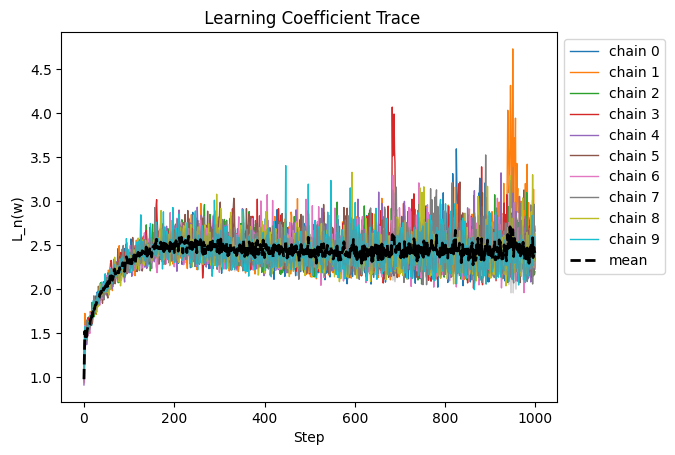

<Figure size 1200x900 with 0 Axes>

Chain 4:  92%|█████████▏| 918/1000 [6:10:41<08:00,  5.86s/it]      2024-02-10 13:31:47.514 python[22739:21431382] Error creating directory 
 The volume ‚ÄúMacintosh HD‚Äù is out of space. You can‚Äôt save the file ‚Äúmpsgraph-22739-2024-02-10_13_31_47-1406932467‚Äù because the volume ‚ÄúMacintosh HD‚Äù is out of space.
Chain 4:  92%|█████████▏| 919/1000 [6:10:49<08:39,  6.41s/it]2024-02-10 13:31:50.088 python[22739:21431382] Error creating directory 
 The volume ‚ÄúMacintosh HD‚Äù is out of space. You can‚Äôt save the file ‚Äúmpsgraph-22739-2024-02-10_13_31_50-3863562164‚Äù because the volume ‚ÄúMacintosh HD‚Äù is out of space.
Chain 4:  92%|█████████▏| 920/1000 [6:10:51<06:55,  5.20s/it]2024-02-10 13:31:52.370 python[22739:21431382] Error creating directory 
 The volume ‚ÄúMacintosh HD‚Äù is out of space. You can‚Äôt save the file ‚Äúmpsgraph-22739-2024-02-10_13_31_52-4075274360‚Äù because the volume ‚ÄúMacintosh HD‚Äù is out of space.
Chain 4:  92%|█████████▏| 921/1000 [6:10:53<05:41

: 

In [10]:
checkpoints_per_path = '/Users/sienkadounia/lab/ai-futures/Project/normal/'
rlcts_path = '/Users/sienkadounia/lab/ai-futures/Project/normal/'
im_points = [30, 40, 110, 120]
checkpoint_name =  'no_burnin_2000_checkpoint' if not use_adam_op else 'no_burnin_2000_adam_checkpoint'

for i in im_points:
  checkpoint = 'checkpoint-with-noise' + str(i) + '.pth'
  torch.manual_seed(model_seed)
  model = make_resnet18k(model_width, num_classes)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr, momentum=0.9, weight_decay=5e-10) if not use_adam_op else optim.Adam(model.parameters(), lr)
  model.load_state_dict(torch.load(checkpoints_per_path + checkpoint, map_location = device)['model_state'])

  torch.manual_seed(0)
  model_rlcts = estimate_learning_coeff_with_summary(
      model,
      loader=trainloader,
      criterion=criterion,
      sampling_method=SGLD,
      optimizer_kwargs= optim_kwargs,
      num_chains=NUM_CHAINS,  # How many independent chains to run
      num_draws=NUM_DRAWS,  # How many samples to draw per chain
      num_burnin_steps=0,  # How many samples to discard at the beginning of each chain
      num_steps_bw_draws=1,  # How many steps to take between each sample
      device=device,
      )

  current_model = rlcts_path + checkpoint_name + str(i)+ '_rlcts.pt' if not use_label_noise else rlcts_path + checkpoint_name + str(i)+ '_with_noise'+'_rlcts.pt'
  torch.save(model_rlcts, current_model)

  #all_results_mwdd.append(model_rlcts)

  trace = model_rlcts.pop("loss/trace")

  print(f"Lambda hat estimates for {checkpoint}: ")
  print(yaml.dump(model_rlcts))
  plot_trace(trace, 'L_n(w)', x_axis='Step', title=' Learning Coefficient Trace', plot_mean=False, plot_std=False, fig_size=(12, 9), true_lc = None)
  plt.show()